In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor 
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

In [188]:
df = pd.read_csv("train.csv")

In [189]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [190]:
df.drop(["User_ID", "Product_ID"], axis=1, inplace=True)

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Gender                      550068 non-null  object 
 1   Age                         550068 non-null  object 
 2   Occupation                  550068 non-null  int64  
 3   City_Category               550068 non-null  object 
 4   Stay_In_Current_City_Years  550068 non-null  object 
 5   Marital_Status              550068 non-null  int64  
 6   Product_Category_1          550068 non-null  int64  
 7   Product_Category_2          376430 non-null  float64
 8   Product_Category_3          166821 non-null  float64
 9   Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 42.0+ MB


In [192]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Occupation,550068.0,8.076707,6.522660,0.0,2.0,7.0,14.0,20.0
Marital_Status,550068.0,0.409653,0.491770,0.0,0.0,0.0,1.0,1.0
Product_Category_1,550068.0,5.404270,3.936211,1.0,1.0,5.0,8.0,20.0
Product_Category_2,376430.0,9.842329,5.086590,2.0,5.0,9.0,15.0,18.0
Product_Category_3,166821.0,12.668243,4.125338,3.0,9.0,14.0,16.0,18.0
Purchase,550068.0,9263.968713,5023.065394,12.0,5823.0,8047.0,12054.0,23961.0


There are no outliers present because there is no significant difference between the mean and the 50th percentile. However, in the 'purchase' column, there is a slight difference between the mean and the 50th percentile, but at this stage, I am not completely certain about the presence of outliers. A box plot is required for full confirmation


In [193]:
df["Gender"].value_counts() / len(df) * 100

M    75.310507
F    24.689493
Name: Gender, dtype: float64

In [194]:
df["Age"].value_counts() / len(df) * 100

26-35    39.919974
36-45    19.999891
18-25    18.117760
46-50     8.308246
51-55     6.999316
55+       3.909335
0-17      2.745479
Name: Age, dtype: float64

Apply label encoding to the 'gender' column and custom encoding to the 'age' column.


In [195]:
nan_cols = df.isnull().mean() * 100
nan_cols[nan_cols > 0]

Product_Category_2    31.566643
Product_Category_3    69.672659
dtype: float64

For imputing the NaN values, I will perform exploratory data analysis (EDA) to check if `Age`, `Gender`, or any other factors are dependent on `Product_Category_2` and `Product_Category_3`. Based on the results, I will impute the missing values in these columns.


In [196]:
df.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [197]:
for i in range(1, 4):
    print(
        f"Unique values of Product_Category_{i}: {df[f'Product_Category_{i}'].unique().tolist()}"
    )

Unique values of Product_Category_1: [3, 1, 12, 8, 5, 4, 2, 6, 14, 11, 13, 15, 7, 16, 18, 10, 17, 9, 20, 19]
Unique values of Product_Category_2: [nan, 6.0, 14.0, 2.0, 8.0, 15.0, 16.0, 11.0, 5.0, 3.0, 4.0, 12.0, 9.0, 10.0, 17.0, 13.0, 7.0, 18.0]
Unique values of Product_Category_3: [nan, 14.0, 17.0, 5.0, 4.0, 16.0, 15.0, 8.0, 9.0, 13.0, 6.0, 12.0, 3.0, 18.0, 11.0, 10.0]


<Axes: xlabel='Age', ylabel='Purchase'>

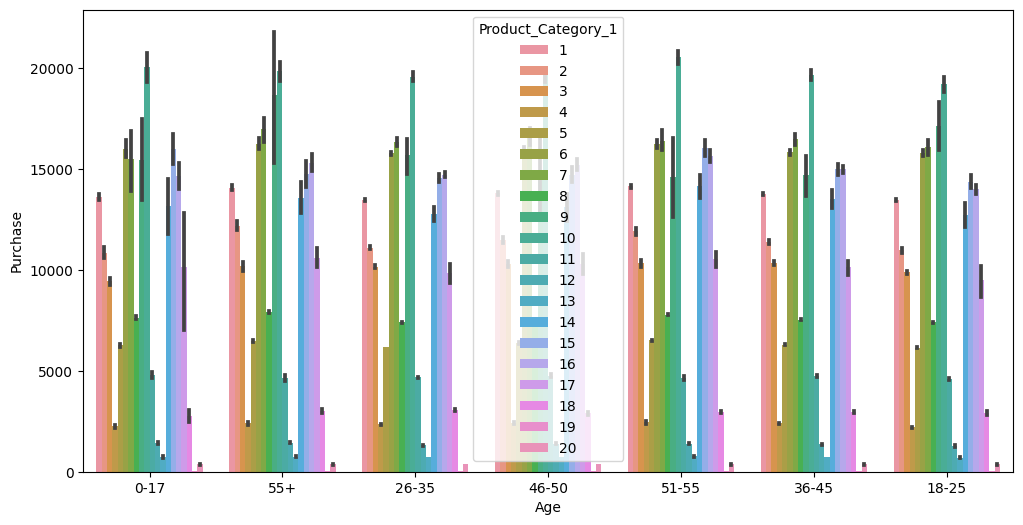

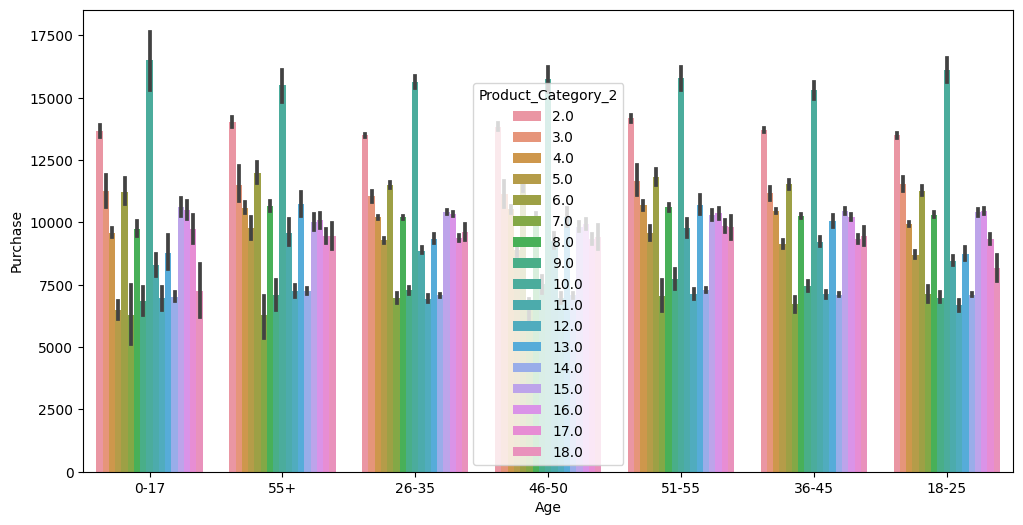

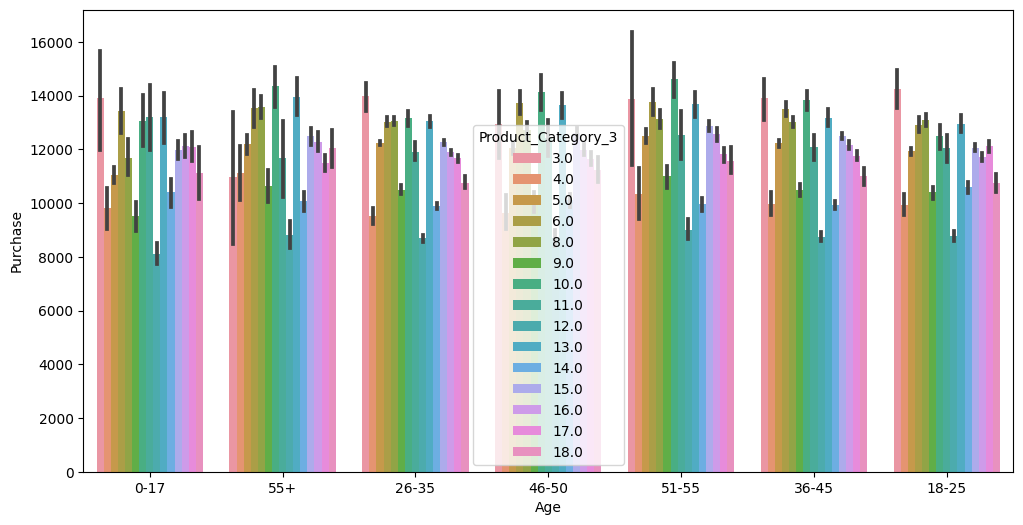

In [198]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, y="Purchase", x="Age", hue="Product_Category_1")
plt.figure(figsize=(12, 6))
sns.barplot(data=df, y="Purchase", x="Age", hue="Product_Category_2")
plt.figure(figsize=(12, 6))
sns.barplot(data=df, y="Purchase", x="Age", hue="Product_Category_3")

<Axes: xlabel='Gender', ylabel='Purchase'>

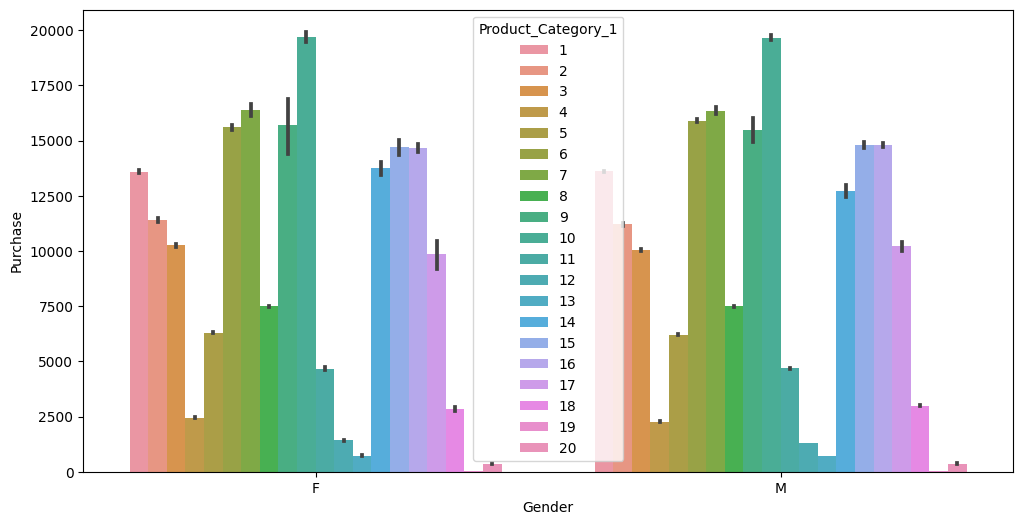

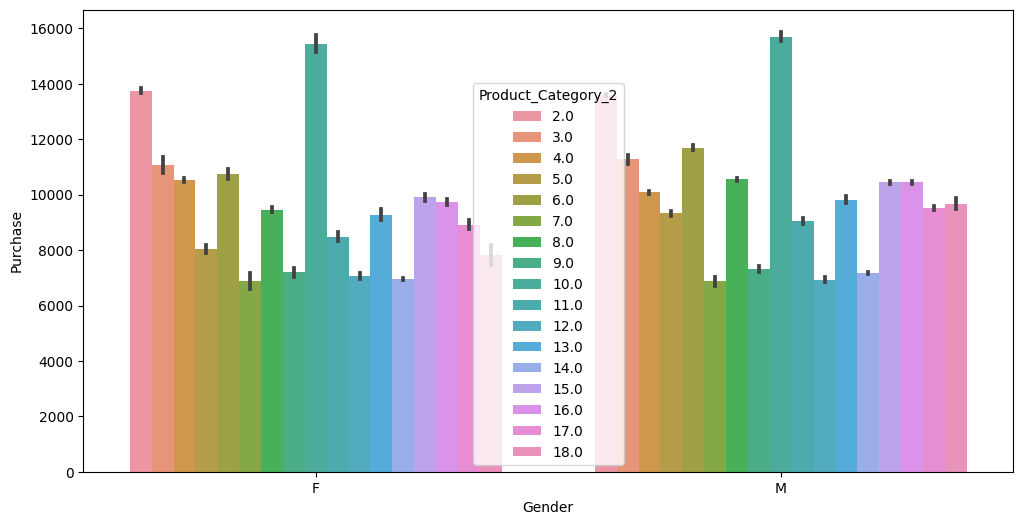

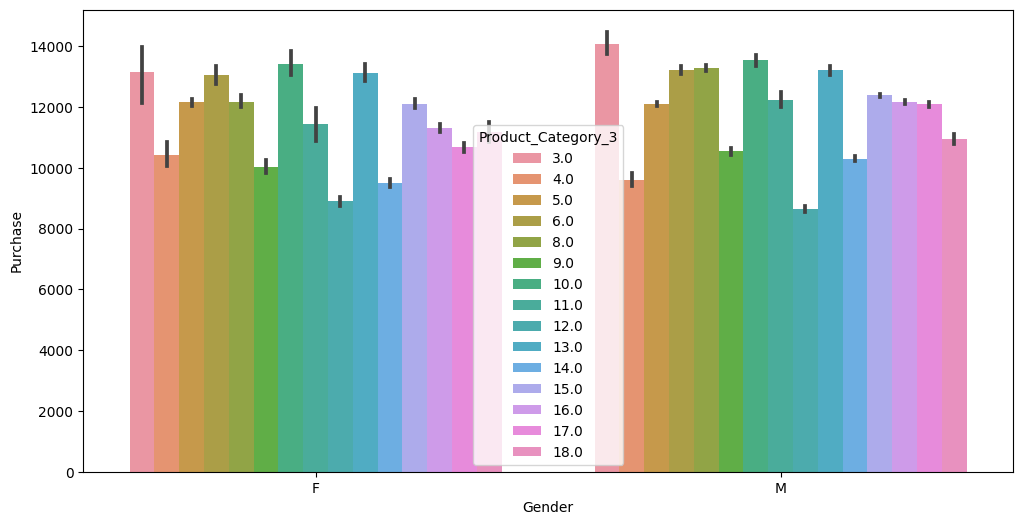

In [199]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, y="Purchase", x="Gender", hue="Product_Category_1")
plt.figure(figsize=(12, 6))
sns.barplot(data=df, y="Purchase", x="Gender", hue="Product_Category_2")
plt.figure(figsize=(12, 6))
sns.barplot(data=df, y="Purchase", x="Gender", hue="Product_Category_3")

Since people tend to buy similar kinds of products (in this data) across different age groups and genders, I will directly impute the missing values with the mode, without any grouping.


In [200]:
df["Product_Category_2"].fillna(df["Product_Category_2"].mode()[0], inplace=True)
df["Product_Category_3"].fillna(df["Product_Category_3"].mode()[0], inplace=True)
df["Product_Category_2"] = df["Product_Category_2"].astype(int)
df["Product_Category_3"] = df["Product_Category_3"].astype(int)

In [201]:
nan_cols = df.isnull().mean() * 100
nan_cols[nan_cols > 0]

Series([], dtype: float64)

In [202]:
df.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,F,0-17,10,A,2,0,3,8,16,8370
1,F,0-17,10,A,2,0,1,6,14,15200
2,F,0-17,10,A,2,0,12,8,16,1422
3,F,0-17,10,A,2,0,12,14,16,1057
4,M,55+,16,C,4+,0,8,8,16,7969


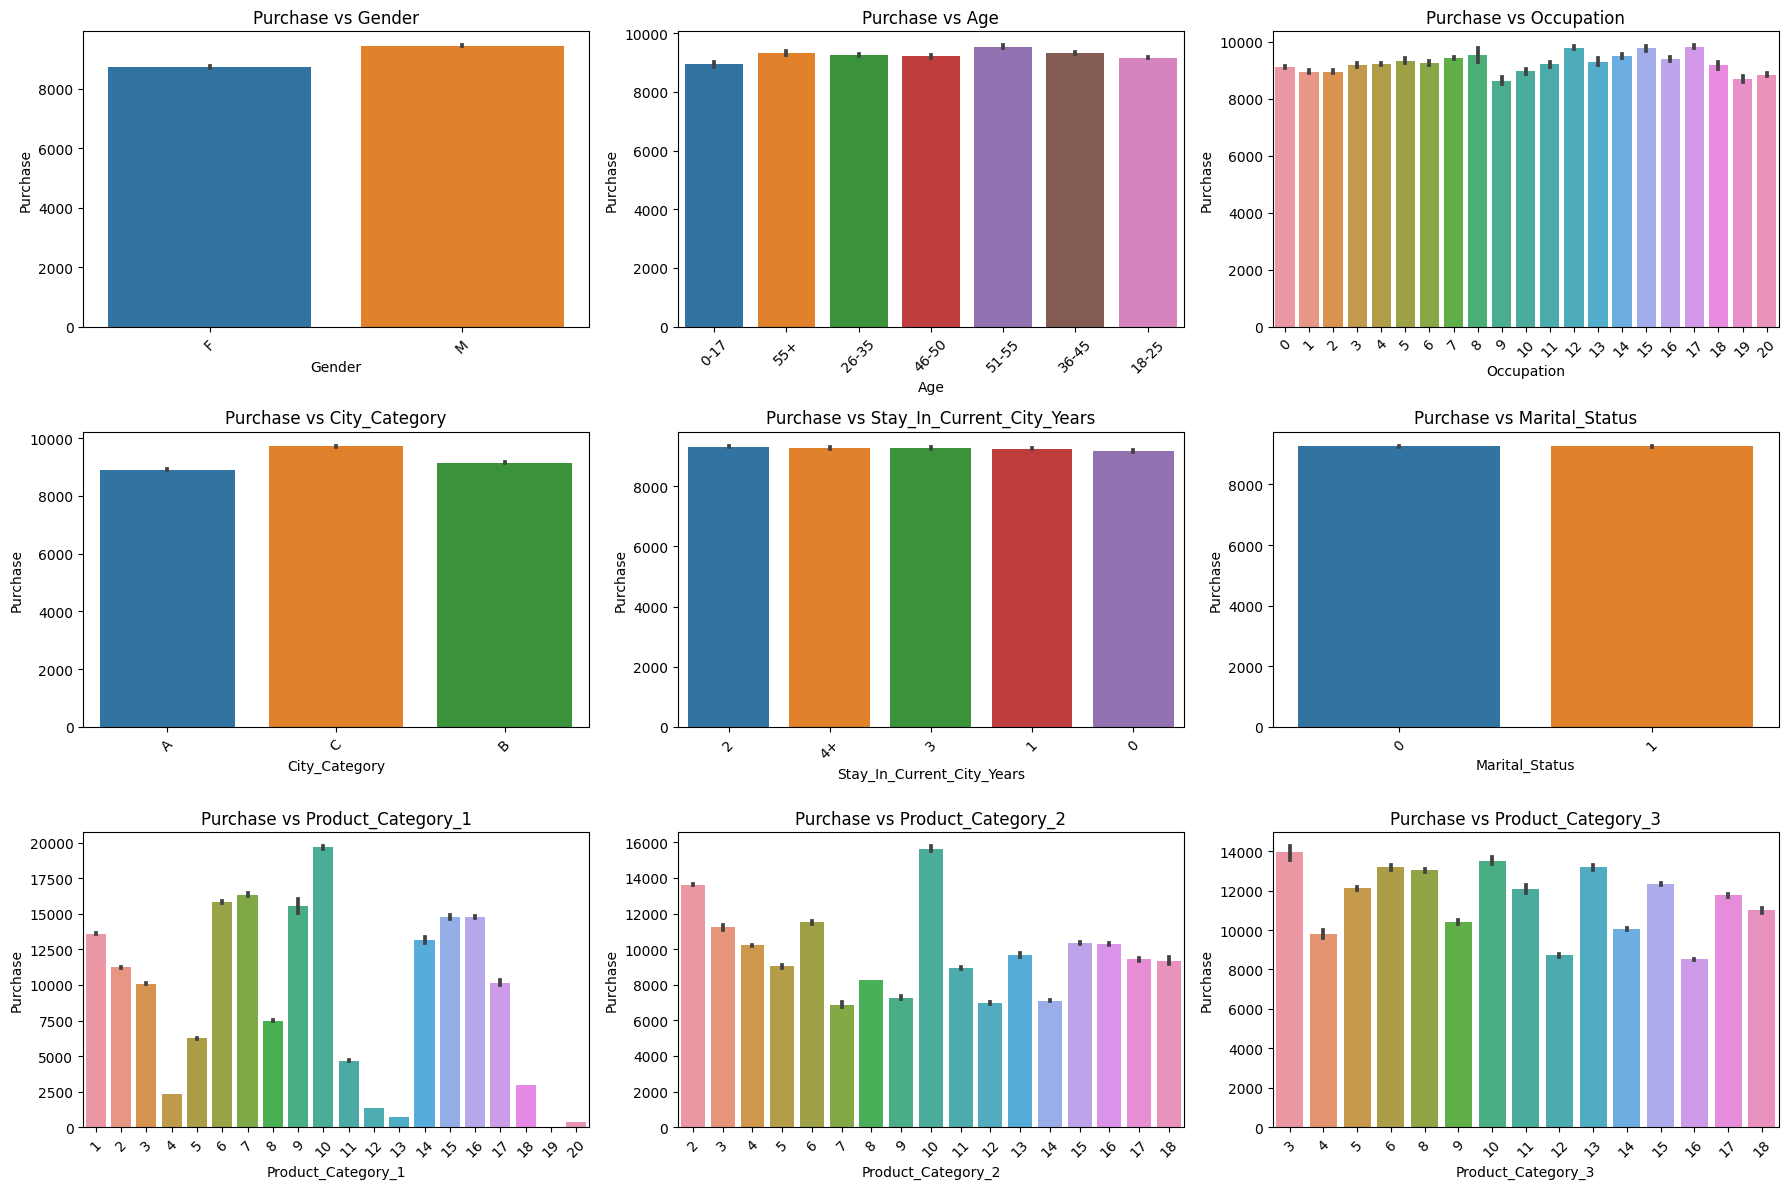

In [203]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()
columns_to_plot = df.columns.to_list()[:-1]
for i, col in enumerate(columns_to_plot):
    sns.barplot(data=df, y="Purchase", x=col, ax=axes[i])
    axes[i].set_title(f"Purchase vs {col}")
    axes[i].tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

In [204]:
for col in df.columns.to_list()[:-1]:
    print(f"Unique values of {col}: {df[col].unique().tolist()}")

Unique values of Gender: ['F', 'M']
Unique values of Age: ['0-17', '55+', '26-35', '46-50', '51-55', '36-45', '18-25']
Unique values of Occupation: [10, 16, 15, 7, 20, 9, 1, 12, 17, 0, 3, 4, 11, 8, 19, 2, 18, 5, 14, 13, 6]
Unique values of City_Category: ['A', 'C', 'B']
Unique values of Stay_In_Current_City_Years: ['2', '4+', '3', '1', '0']
Unique values of Marital_Status: [0, 1]
Unique values of Product_Category_1: [3, 1, 12, 8, 5, 4, 2, 6, 14, 11, 13, 15, 7, 16, 18, 10, 17, 9, 20, 19]
Unique values of Product_Category_2: [8, 6, 14, 2, 15, 16, 11, 5, 3, 4, 12, 9, 10, 17, 13, 7, 18]
Unique values of Product_Category_3: [16, 14, 17, 5, 4, 15, 8, 9, 13, 6, 12, 3, 18, 11, 10]


In [205]:
Gender_label_encoder = LabelEncoder()
Age_label_encoder=LabelEncoder()
City_Category_label_encoder=LabelEncoder()
Stay_In_Current_City_Years_label_encoder=LabelEncoder()

In [206]:
df["Gender"] = Gender_label_encoder.fit_transform(df["Gender"])
df["Age"] = Age_label_encoder.fit_transform(df["Age"])
df["City_Category"] = City_Category_label_encoder.fit_transform(df["City_Category"])
df["Stay_In_Current_City_Years"] = Stay_In_Current_City_Years_label_encoder.fit_transform(
    df["Stay_In_Current_City_Years"]
)

In [207]:
df.sample()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
261626,1,3,0,1,3,0,1,8,13,15880


In [208]:
df.dtypes

Gender                        int32
Age                           int32
Occupation                    int64
City_Category                 int32
Stay_In_Current_City_Years    int32
Marital_Status                int64
Product_Category_1            int64
Product_Category_2            int32
Product_Category_3            int32
Purchase                      int64
dtype: object

In [209]:
for col in df.columns.to_list()[:-1]:
    print(f"Unique values of {col}: {df[col].unique().tolist()}")

Unique values of Gender: [0, 1]
Unique values of Age: [0, 6, 2, 4, 5, 3, 1]
Unique values of Occupation: [10, 16, 15, 7, 20, 9, 1, 12, 17, 0, 3, 4, 11, 8, 19, 2, 18, 5, 14, 13, 6]
Unique values of City_Category: [0, 2, 1]
Unique values of Stay_In_Current_City_Years: [2, 4, 3, 1, 0]
Unique values of Marital_Status: [0, 1]
Unique values of Product_Category_1: [3, 1, 12, 8, 5, 4, 2, 6, 14, 11, 13, 15, 7, 16, 18, 10, 17, 9, 20, 19]
Unique values of Product_Category_2: [8, 6, 14, 2, 15, 16, 11, 5, 3, 4, 12, 9, 10, 17, 13, 7, 18]
Unique values of Product_Category_3: [16, 14, 17, 5, 4, 15, 8, 9, 13, 6, 12, 3, 18, 11, 10]


In [210]:
df.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,0,0,10,0,2,0,3,8,16,8370
1,0,0,10,0,2,0,1,6,14,15200
2,0,0,10,0,2,0,12,8,16,1422
3,0,0,10,0,2,0,12,14,16,1057
4,1,6,16,2,4,0,8,8,16,7969


In [211]:
X_train = df.drop("Purchase", axis=1)  # Features
y_train = df["Purchase"]  # Target

In [212]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "CatBoost Regressor": CatBoostRegressor(
        iterations=500, learning_rate=0.1, depth=6, random_seed=42, verbose=0
    ),
    "LGBM Regressor": lgb.LGBMRegressor(
        n_estimators=500, learning_rate=0.1, max_depth=6, random_state=42, verbose=0
    ),
}

In [213]:
def print_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"Performance Metrics for {model_name}:")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}\n")
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    axs[0].scatter(y_true, y_pred, c="yellow", alpha=0.5)
    axs[0].set_xlabel("True Purchase")
    axs[0].set_ylabel("Predicted Purchase")
    axs[0].set_title("True vs Predicted Purchase")
    axs[1].scatter(range(len(y_true)), y_true, c="blue", label="True Values", alpha=0.5)
    axs[1].scatter(
        range(len(y_pred)), y_pred, c="red", label="Predicted Values", alpha=0.5
    )
    axs[1].set_xlabel("Index")
    axs[1].set_ylabel("Purchase")
    axs[1].set_title("True vs Predicted Purchase Over Index")
    axs[1].legend()
    fig.suptitle(f"Performance Metrics and Graphs for {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Performance Metrics for Linear Regression - Training Set:
Mean Absolute Error: 3581.1869869234424
Mean Squared Error: 21927066.77079762
R-squared: 0.13095220033380373



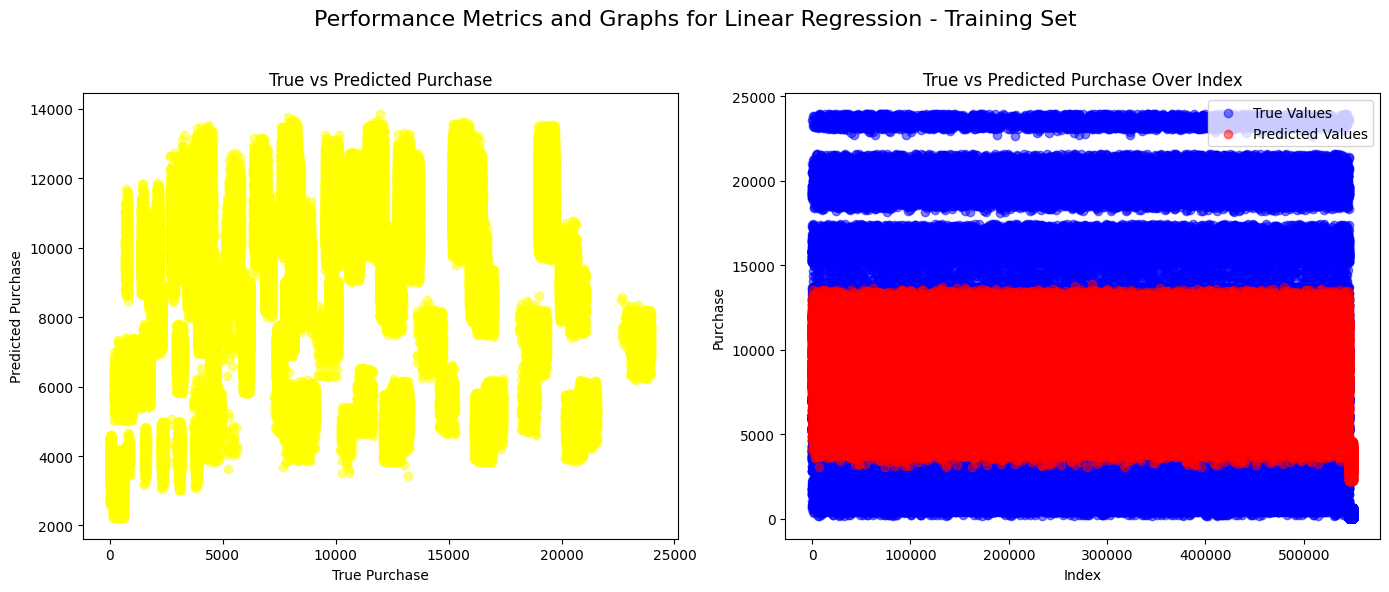

________________________________________________________________________________
Performance Metrics for Random Forest - Training Set:
Mean Absolute Error: 1735.3434680113605
Mean Squared Error: 5760363.0223558685
R-squared: 0.771696284679358



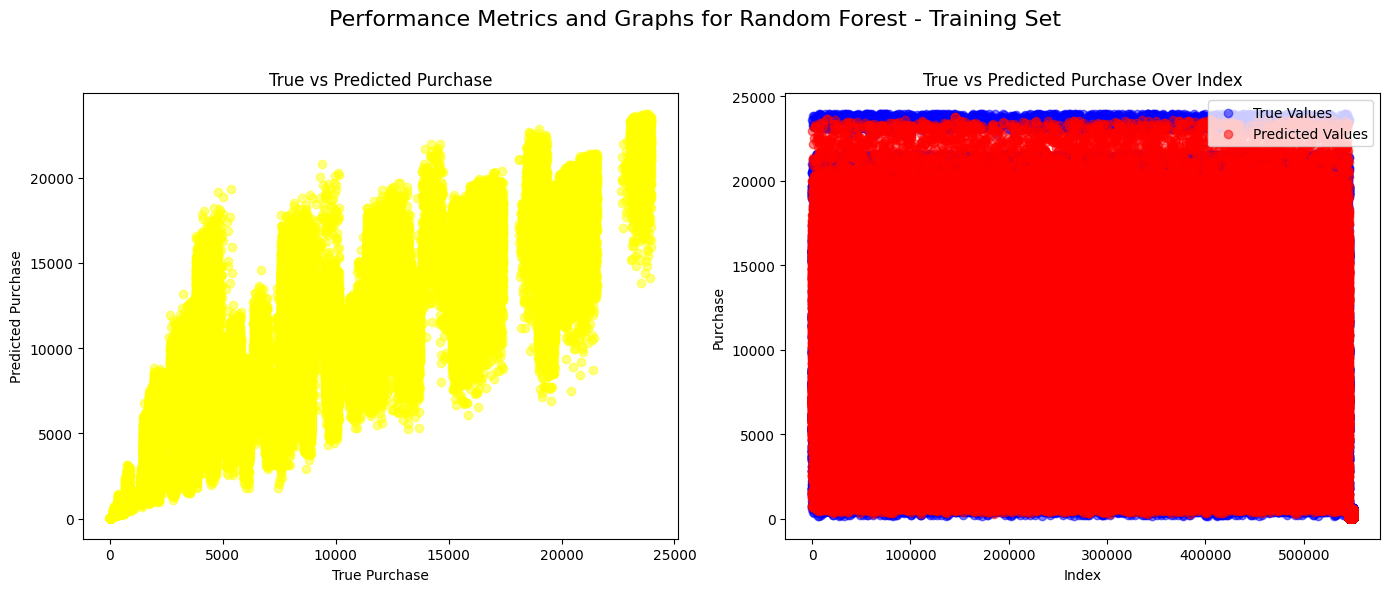

________________________________________________________________________________
Performance Metrics for Gradient Boosting - Training Set:
Mean Absolute Error: 2262.066492172919
Mean Squared Error: 8886733.055919051
R-squared: 0.6477870985118375



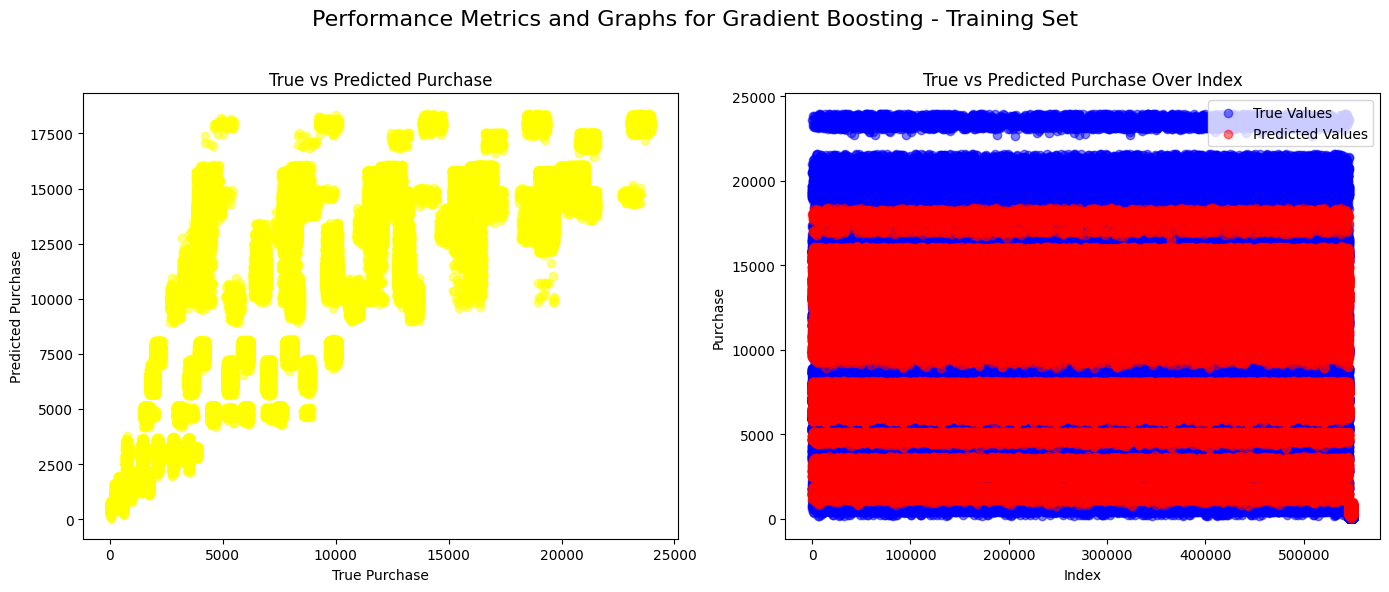

________________________________________________________________________________
Performance Metrics for CatBoost Regressor - Training Set:
Mean Absolute Error: 2168.8102597371826
Mean Squared Error: 8357365.384893081
R-squared: 0.6687678258716969



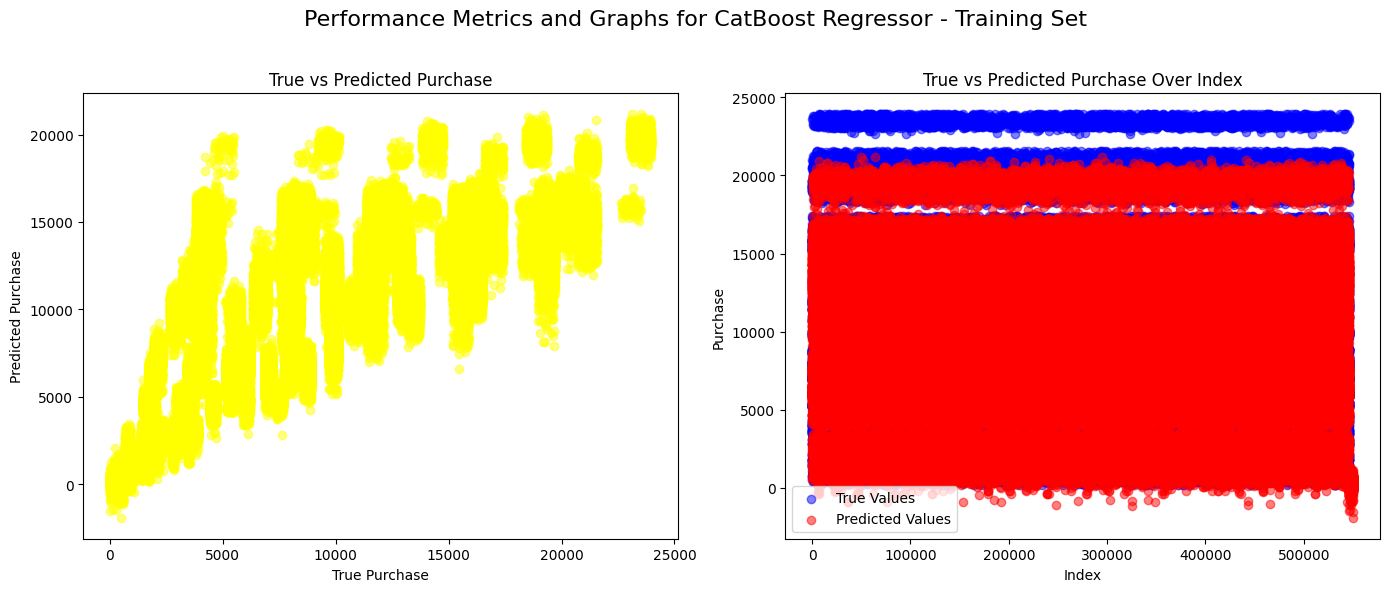

________________________________________________________________________________
Performance Metrics for LGBM Regressor - Training Set:
Mean Absolute Error: 2142.350155559265
Mean Squared Error: 8182447.033388383
R-squared: 0.6757004635147239



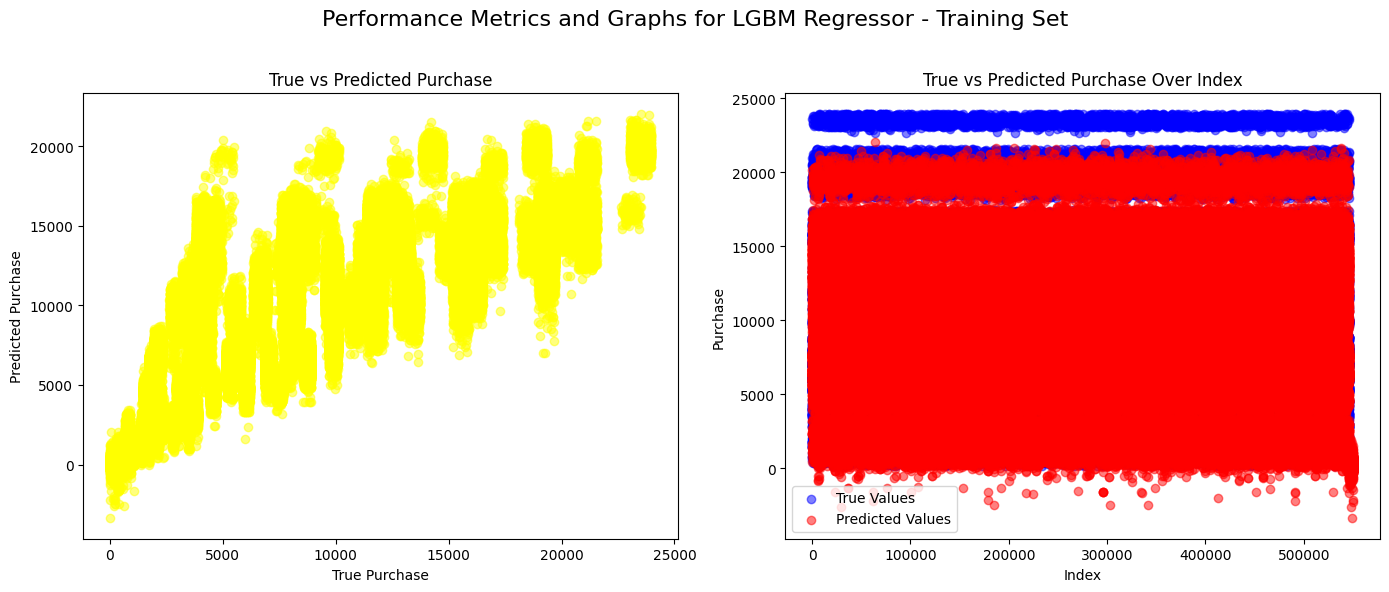

________________________________________________________________________________


In [214]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    print_metrics(y_train, y_train_pred, f"{model_name} - Training Set")
    print("_" * 80)

### Conclusion:

**CatBoost** and **LGBM Regressor** are the top-performing models, offering balanced and strong predictive power with the best R-squared values on the testing set.


### Preparing Test Data

In [215]:
df_test = pd.read_csv("test.csv")

In [216]:
df_test.drop(["User_ID", "Product_ID"], axis=1, inplace=True)

In [217]:
nan_cols = df_test.isnull().mean() * 100
nan_cols[nan_cols > 0]

Product_Category_2    30.969311
Product_Category_3    69.590195
dtype: float64

In [218]:
df_test["Product_Category_2"].fillna(
    df_test["Product_Category_2"].mode()[0], inplace=True
)
df_test["Product_Category_3"].fillna(
    df_test["Product_Category_3"].mode()[0], inplace=True
)
df_test["Product_Category_2"] = df_test["Product_Category_2"].astype(int)
df_test["Product_Category_3"] = df_test["Product_Category_3"].astype(int)

In [219]:
nan_cols = df_test.isnull().mean() * 100
nan_cols[nan_cols > 0]

Series([], dtype: float64)

In [220]:
df_test["Gender"] = Gender_label_encoder.transform(df_test["Gender"])
df_test["Age"] = Age_label_encoder.transform(df_test["Age"])
df_test["City_Category"] = City_Category_label_encoder.transform(df_test["City_Category"])
df_test["Stay_In_Current_City_Years"] = Stay_In_Current_City_Years_label_encoder.transform(
    df_test["Stay_In_Current_City_Years"]
)

In [221]:
X_test = df_test

In [222]:
X_test.sample()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
204332,1,2,12,1,4,0,6,16,16


In [223]:
lgbm=lgb.LGBMRegressor(
        n_estimators=500, learning_rate=0.1, max_depth=6, random_state=42, verbose=0
    )

In [224]:
lgbm.fit(X_train, y_train)

LGBMRegressor(max_depth=6, n_estimators=500, random_state=42, verbose=0)

In [225]:
y_test_pred = lgbm.predict(X_test)

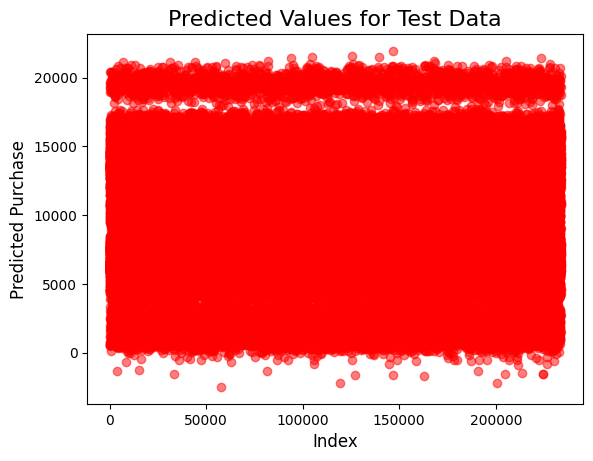

In [228]:
plt.scatter(range(len(y_test_pred)), y_test_pred, c="red", label="Predicted Values", alpha=0.5)
plt.title("Predicted Values for Test Data", fontsize=16)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Predicted Purchase", fontsize=12)
plt.show()